# Assignment 04

Randomized Benchmarking Protocol

<ol>
<li> Quantum information processor is the non-scalability of completely characterizing the noise affecting a quantum system via process tomography</li>
    <li>In addition, process tomography is sensitive to noise in the pre- and post rotation gates plus the measurements (SPAM errors)</li>
    <li> A complete characterization of the noise is useful because it allows for the determination of good error-correction schemes, and thus the possibility of reliable transmission of quantum information</li>
<li>Since complete process tomography is infeasible for large systems, there is growing interest in scalable methods for partially characterizing the noise affecting a quantum system</li>
    <li>A scalable (in the number of qubits comprising the system) and robust algorithm for benchmarking the full set of Clifford gates by a single parameter using randomization techniques was presented</li>
    <li>The concept of using randomization methods for benchmarking quantum gates is commonly called Randomized Benchmarking (RB)</li>

</ol>


So here we go with simple implementation of Randomized Protocol!!!!!!!!!!!!!!!!!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import qiskit.ignis.verification.randomized_benchmarking as rb
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

/tmp/ipykernel_4151/3475800622.py:4: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb


In [2]:
nQ = 3 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

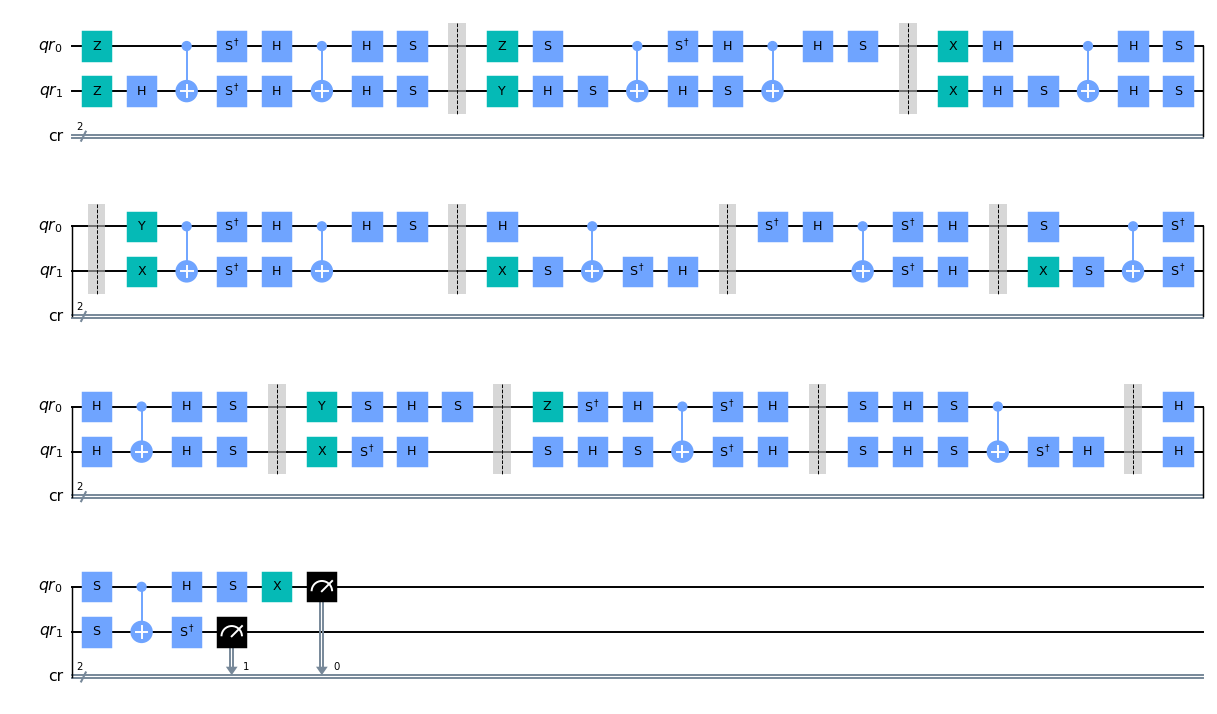

In [3]:
rb_circs[0][1].draw("mpl", scale=0.7)


In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [5]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0


/tmp/ipykernel_4151/3484222176.py:13: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj,


After seed 0, alpha: 0.982824, EPC: 0.012882
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.981174, EPC: 0.014119
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.980775, EPC: 0.014419
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.980535, EPC: 0.014599
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.980086, EPC: 0.014936


## Here EPC is error per Clifford

Ultimately we will try to print the graph

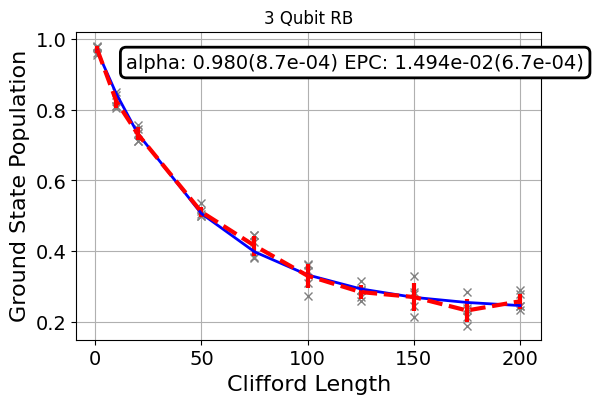

In [8]:
plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=12)

plt.show()

## Try to increase the qubits to understand the effect of error